# Notebook for charts and comparisons for LZW EOP

## 1. LZW dictionary growth for 16-bit code

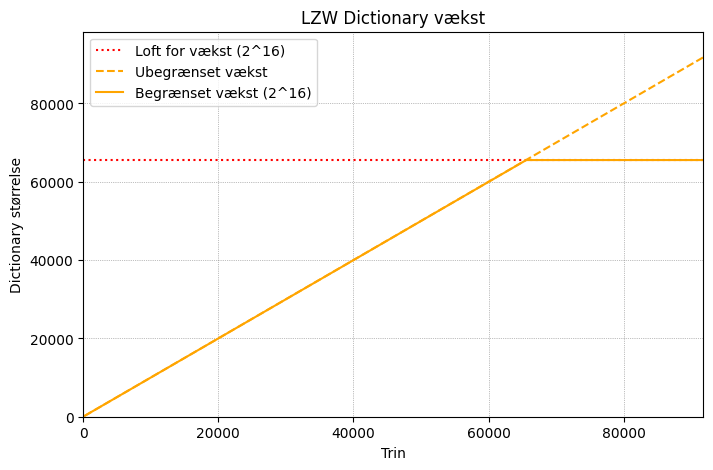

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

dictionary_cap = 2**16 # 16-bit dictionary keys

def linear_function(x, slope=1, intercept=0, y_cap=None):
    y = slope * x + intercept
    if y_cap is not None:
        y = np.minimum(y, y_cap)
    return y

x = np.linspace(255, dictionary_cap * 1.5, dictionary_cap)

y_capped = linear_function(x, slope=1, intercept=0, y_cap=dictionary_cap)
y_uncapped = linear_function(x, slope=1, intercept=0, y_cap=None)

plt.figure(figsize=(8, 5))
plt.axhline(y=dictionary_cap, color='red', linestyle=':', label=f"Loft for vækst (2^16)")  # Cap line
plt.plot(x, y_uncapped, label="Ubegrænset vækst", color='orange', linestyle='--')  # Uncapped function
plt.plot(x, y_capped, label=f"Begrænset vækst (2^16)", color='orange',)  # Capped function
plt.xlabel("Trin")
plt.ylabel("Dictionary størrelse")
plt.ylim(0, dictionary_cap * 1.5)
plt.xlim(0, dictionary_cap * 1.4)
plt.title("LZW Dictionary vækst")
plt.legend(loc='upper left')
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.show()

## 2. Entropy and datacompression visualization

### 2.1 Extraction of files and meta data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import math

def read_file(file_path):
    with open(file_path, "rb") as file:
        lines = file.read()
    return lines

def nth_order_entropy(text, n):
    if n < 0:
        raise ValueError("Order must be >= 0")

    context_counts = defaultdict(Counter)
    total_contexts = 0

    # Loop over the text to gather context and next char
    for i in range(len(text) - n):
        context = text[i:i + n]
        next_char = text[i + n]
        context_counts[context][next_char] += 1
        total_contexts += 1

    entropy = 0
    for context, counter in context_counts.items():
        total = sum(counter.values())
        for _, count in counter.items():
            p = count / total
            entropy += (count / total_contexts) * -math.log2(p)

    return entropy

df = pd.DataFrame()

for file in ["hamlet", "bible", "e", "world192", "bigfile"]:
    for type in [".txt", "_compressed"]:
        file_data = read_file(f"../files/{file}{type}")

        freq = {}
        for char in file_data:
            if char in freq:
                freq[char] += 1
            else:
                freq[char] = 1

        # Calculate the total number of characters
        total_chars = len(file_data)

        # Calculate the entropy
        entropy_0 = nth_order_entropy(file_data, 0)
        entropy_1 = nth_order_entropy(file_data, 1)
        entropy_2 = nth_order_entropy(file_data, 2)        
        max_entropy = np.log2(len(freq))
        

        type = type.replace("_", "")

        file_stats = {
            "file": file,
            "type": type if type != ".txt" else "original",
            "total_characters": total_chars,
            "unique_characters": len(freq),
            "entropy_0": entropy_0,
            "entropy_1": entropy_1,
            "entropy_2": entropy_2,
            "max_entropy": max_entropy,
        }
        file_df = pd.DataFrame([file_stats])
        df = pd.concat([df, file_df], ignore_index=True)

display(df)



,file,type,total_characters,unique_characters,entropy_0,entropy_1,entropy_2,max_entropy
0,hamlet,original,180637,65,4.848869,3.413348,2.579362,6.022368
1,hamlet,compressed,86128,256,7.635163,6.870586,1.802859,8.000000
2,bible,original,4047392,63,4.342751,3.269098,2.478621,5.977280
3,bible,compressed,1425636,256,7.966521,7.572659,3.955063,8.000000
4,e,original,4638690,4,1.999821,1.981416,1.963235,2.000000
5,e,compressed,1221478,256,7.989255,7.857031,4.251561,8.000000
6,world192,original,2473400,94,4.998314,3.660469,2.770645,6.554589
7,world192,compressed,933702,256,7.961682,7.421236,2.986949,8.000000
8,bigfile,original,10100000,64,5.998230,5.997810,5.979448,6.000000
9,bigfile,compressed,9152520,256,7.540702,7.047450,6.212020,8.000000


In [3]:
info_df = df.copy()
info_df["size_mb"] = info_df["total_characters"] / 1024 / 1024
display(info_df[info_df["type"] == "original"][["file", "total_characters", "unique_characters", "size_mb"]].sort_values("file"))

,file,total_characters,unique_characters,size_mb
2,bible,4047392,63,3.859894
8,bigfile,10100000,64,9.632111
4,e,4638690,4,4.423800
0,hamlet,180637,65,0.172269
6,world192,2473400,94,2.358818


### 2.2 Entropy comparison

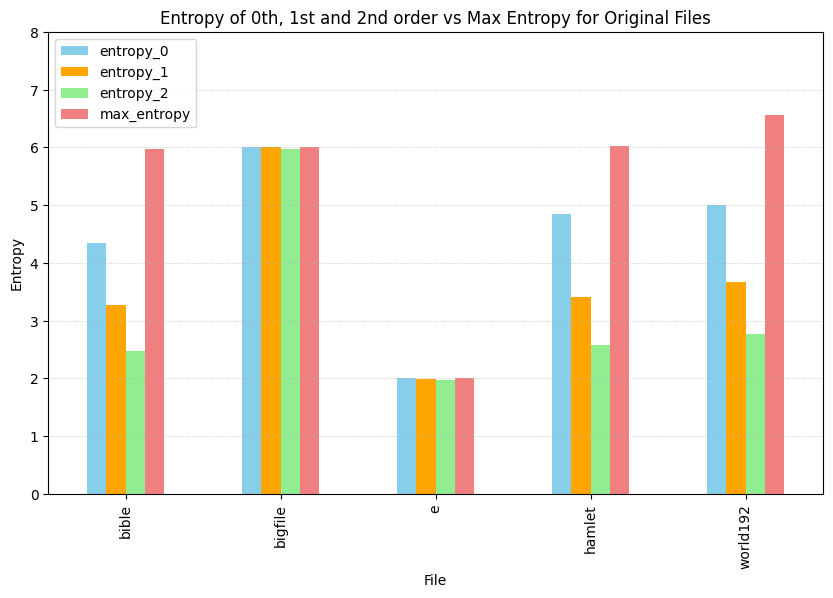

In [4]:
# Bar chart for entropy comparison

df_org = df[df["type"] == "original"]
df_org = df_org.sort_values(by="file")

df_org.plot(
    x="file",
    y=["entropy_0", "entropy_1", "entropy_2", "max_entropy"],
    kind="bar",
    figsize=(10, 6),
    title="Entropy of 0th, 1st and 2nd order vs Max Entropy for Original Files",
    ylabel="Entropy",
    xlabel="File",
    color=["skyblue", "orange", "lightgreen", "lightcoral"],
)
plt.ylim(0, 8)
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.show()

### 2.3 Original, estimated and compressed size comparison

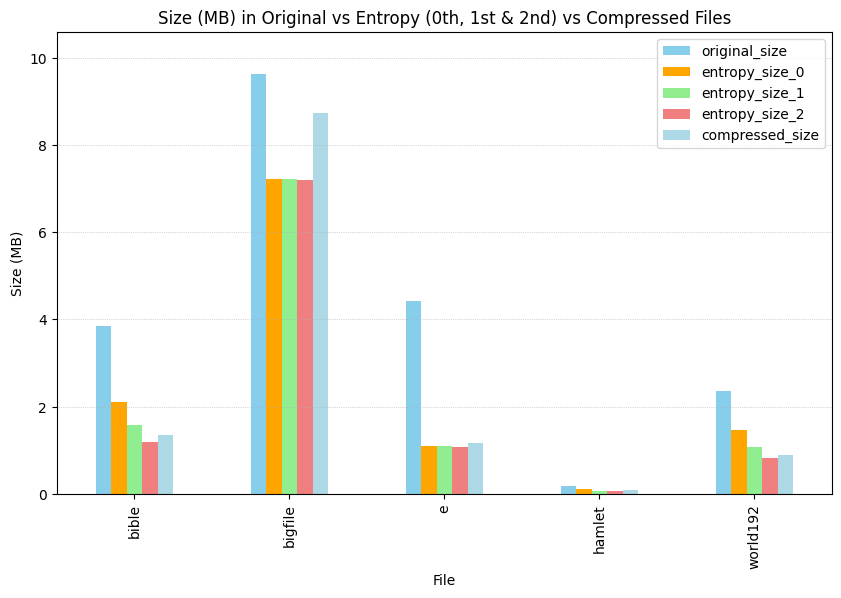

In [5]:
merged_df = merged_df = df.pivot(index='file', columns='type').reset_index()
merged_df.columns = ["_".join(col).strip() for col in merged_df.columns.values]
merged_df = merged_df.rename(columns={"file_": "file"})
merged_df = merged_df.rename(columns={"entropy_0_original": "entropy_0", "entropy_1_original": "entropy_1", "entropy_2_original": "entropy_2", "total_characters_original": "total_bytes_original", "total_characters_compressed": "total_bytes_compressed"})

actual_df = merged_df[["file", "total_bytes_original", "total_bytes_compressed", "entropy_0", "entropy_1", "entropy_2"]]
actual_df = actual_df.sort_values(by="file")

# Get the number of bits the different order entropies would take
actual_df["entropy_size_0"] = (actual_df["entropy_0"] * actual_df["total_bytes_original"]) / 8
actual_df["entropy_size_1"] = (actual_df["entropy_1"] * actual_df["total_bytes_original"]) / 8
actual_df["entropy_size_2"] = (actual_df["entropy_2"] * actual_df["total_bytes_original"]) / 8
actual_df = actual_df.rename(columns={"total_bytes_original": "original_size", "total_bytes_compressed": "compressed_size"})

# convert to MB
for col in ["original_size", "compressed_size", "entropy_size_0", "entropy_size_1", "entropy_size_2"]:
    actual_df[col] = actual_df[col] / (1024 * 1024)

actual_df.plot(
    x="file",
    y=["original_size", "entropy_size_0", "entropy_size_1", "entropy_size_2", "compressed_size"],
    kind="bar",
    figsize=(10, 6),
    title="Size (MB) in Original vs Entropy (0th, 1st & 2nd) vs Compressed Files",
    ylabel="Size (MB)",
    xlabel="File",
    color=["skyblue", "orange", "lightgreen", "lightcoral", "lightblue"],
)

plt.ylim(0, 1.1 * actual_df["original_size"].max())
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.show()


### 2.4 Uncompressed and compressed comparison

In [6]:
# Calulate compression ratio
actual_df["compression_ratio"] = actual_df["original_size"] / actual_df["compressed_size"]

# Calculate compression percentage
actual_df["compression_percentage"] = (1 - (actual_df["compressed_size"] / actual_df["original_size"])) * 100

display(actual_df[["file", "original_size", "compressed_size", "entropy_2", "compression_ratio", "compression_percentage"]].sort_values("entropy_2", ascending=True))


,file,original_size,compressed_size,entropy_2,compression_ratio,compression_percentage
2,e,4.423800,1.164892,1.963235,3.797604,73.667609
0,bible,3.859894,1.359592,2.478621,2.839008,64.776429
3,hamlet,0.172269,0.082138,2.579362,2.097309,52.319846
4,world192,2.358818,0.890448,2.770645,2.649025,62.250263
1,bigfile,9.632111,8.728523,5.979448,1.103521,9.380990


## 3. Compression rates 

### 3.1 Extraction of compression stats

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def read_file(file_path):
    with open(file_path, "rb") as file:
        lines = file.read()
    return lines

files = {}
for file in ["hamlet", "bible", "e", "world192", "bigfile"]:
    file_data = read_file(f"../stats/{file}_stats")
    file_data = file_data.decode("utf-8").split("\n")[:-1]

    types = {
        "comp_rate": [],
        "num_symbols": [],
    }
    for line in file_data:
        vals = line.split(",")
        types["comp_rate"].append(float(vals[0]))
        types["num_symbols"].append(int(float(vals[1])))
        # print(vals)

    types["comp_rate"] = types["comp_rate"]
    types["num_symbols"] = types["num_symbols"]
    files[file] = types

### 3.2 Visualize running compression rate

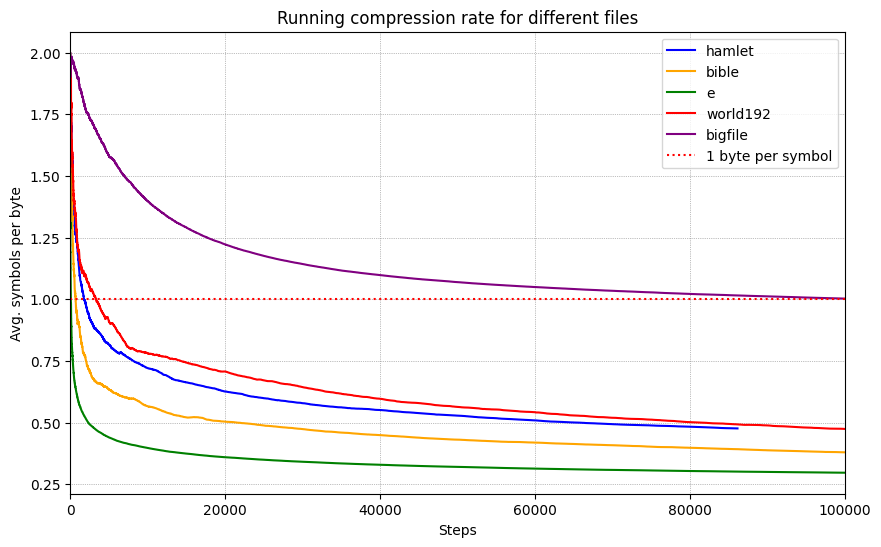

In [8]:
# Line chart for bytes per symbol
colors = {
    "hamlet": "blue",
    "bible": "orange",
    "e": "green",
    "world192": "red",
    "bigfile": "purple"
}

plt.figure(figsize=(10, 6))
for file, data in files.items():
    tmp = []
    for val in data["comp_rate"]:
        tmp.append(val)
        tmp.append(val)
    plt.plot(tmp[:100_000], label=file, color=colors[file])
plt.axhline(y=1, color='red', linestyle=':', label="1 byte per symbol")  # Reference line
#vertical line
plt.title("Running compression rate for different files")
plt.xlabel("Steps")
plt.ylabel("Avg. symbols per byte")
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.xlim(0, 100_000)
# make x tick 
# plt.xticks(np.arange(0, 60001, 10000))
plt.show()


### 3.3 Visualize Symbols per byte growth

hamlet: 90317.5
bible: 2023695.5
e: 2319342.5
world192: 1236699.5
bigfile: 5049999.5


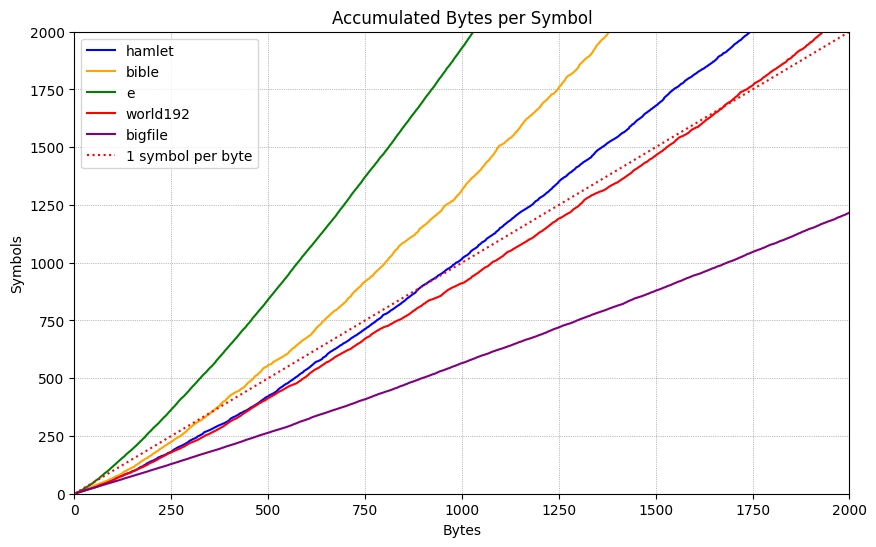

In [9]:
x = np.linspace(0, 1_000_000, 1_000_000)

plt.figure(figsize=(10, 6))
for file, data in files.items():
    syms_per_byte = []
    for i in data["num_symbols"]:
        syms_per_byte.append(i/2)
    
    accum = np.cumsum(syms_per_byte)

    print(f"{file}: {accum[-1]}")

    plt.plot(accum, label=file, color=colors[file])

plt.plot(x, x, color='red', linestyle=':', label="1 symbol per byte")  # Reference line
plt.title("Accumulated Bytes per Symbol")
plt.xlabel("Bytes")
plt.ylabel("Symbols")
plt.legend()
plt.grid(color='gray', linestyle=':', linewidth=0.5)
plt.xlim(0, 2_000)
plt.ylim(0, 2_000)
plt.show()

## 4. Other filetype compairson

### 4.1 Extraction of files and metadata

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import math

def read_file(file_path):
    with open(file_path, "rb") as file:
        lines = file.read()
    return lines

def nth_order_entropy(text, n):
    if n < 0:
        raise ValueError("Order must be >= 0")

    context_counts = defaultdict(Counter)
    total_contexts = 0

    # Loop over the text to gather context and next char
    for i in range(len(text) - n):
        context = text[i:i + n]
        next_char = text[i + n]
        context_counts[context][next_char] += 1
        total_contexts += 1

    entropy = 0
    for context, counter in context_counts.items():
        total = sum(counter.values())
        for _, count in counter.items():
            p = count / total
            entropy += (count / total_contexts) * -math.log2(p)

    return entropy

df = pd.DataFrame()

for file in ["claudeshannon", "rainy-day", "crowd-cheer", ]:
    for type in [".jpg", ".mp3", "_compressed"]:
        
        if file == "claudeshannon" and type == ".mp3":
            continue
        if (file == "crowd-cheer" or file == "rainy-day") and type == ".jpg":
            continue
        file_data = read_file(f"../files/{file}{type}")

        freq = {}
        for char in file_data:
            if char in freq:
                freq[char] += 1
            else:
                freq[char] = 1

        # Calculate the total number of characters
        total_chars = len(file_data)

        # Calculate the entropy
        entropy_0 = nth_order_entropy(file_data, 0)
        entropy_1 = nth_order_entropy(file_data, 1)
        entropy_2 = nth_order_entropy(file_data, 2)        
        max_entropy = np.log2(len(freq))
        
        type = type.replace("_", "")

        file_stats = {
            "file": file,
            "type": type if "." not in type else "original",
            "total_characters": total_chars,
            "unique_characters": len(freq),
            "entropy_0": entropy_0,
            "entropy_1": entropy_1,
            "entropy_2": entropy_2,
            "max_entropy": max_entropy,
            # "entropy size": (relatove_entropy * total_chars) / 8,
            # "redundant_information": 1 - (relatove_entropy / max_entropy)
        }
        file_df = pd.DataFrame([file_stats])
        df = pd.concat([df, file_df], ignore_index=True)

display(df)



,file,type,total_characters,unique_characters,entropy_0,entropy_1,entropy_2,max_entropy
0,claudeshannon,original,312483,256,7.955964,7.555929,2.671670,8.0
1,claudeshannon,compressed,388212,256,7.087568,6.766313,3.665692,8.0
2,rainy-day,original,18599183,256,7.972851,7.909465,7.096330,8.0
3,rainy-day,compressed,22476774,256,7.230966,7.088278,6.447570,8.0
4,crowd-cheer,original,158880,256,7.855789,6.936015,2.014477,8.0
5,crowd-cheer,compressed,192702,256,6.976745,6.472975,3.124583,8.0


### 4.1 Comparison of entropy

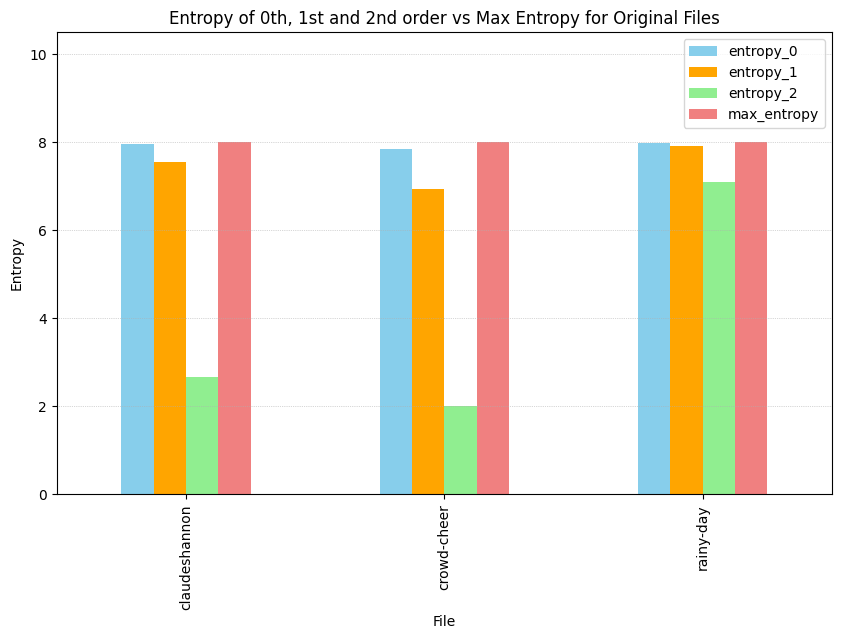

In [11]:
# Bar chart for entropy comparison
df_org = df[df["type"] == "original"]
df_org = df_org.sort_values(by="file")

df_org.plot(
    x="file",
    y=["entropy_0", "entropy_1", "entropy_2", "max_entropy"],
    kind="bar",
    figsize=(10, 6),
    title="Entropy of 0th, 1st and 2nd order vs Max Entropy for Original Files",
    ylabel="Entropy",
    xlabel="File",
    color=["skyblue", "orange", "lightgreen", "lightcoral"],
)
plt.ylim(0, 10.5)
plt.grid(axis="y", linestyle=":", linewidth=0.5)
plt.show()

### 4.3 Comparison on compression results

In [12]:
merged_df = merged_df = df.pivot(index='file', columns='type').reset_index()
merged_df.columns = ["_".join(col).strip() for col in merged_df.columns.values]
merged_df = merged_df.rename(columns={"file_": "file"})
merged_df = merged_df.rename(columns={"entropy_0_original": "entropy_0", "entropy_1_original": "entropy_1", "entropy_2_original": "entropy_2", "total_characters_original": "total_bytes_original", "total_characters_compressed": "total_bytes_compressed"})
merged_df["compression_ratio"] = merged_df["total_bytes_original"] / merged_df["total_bytes_compressed"]
merged_df["compression_percentage"] = (1 - (merged_df["total_bytes_compressed"] / merged_df["total_bytes_original"])) * 100
display(merged_df[["file", "total_bytes_original", "total_bytes_compressed", "compression_ratio", "compression_percentage"]])

,file,total_bytes_original,total_bytes_compressed,compression_ratio,compression_percentage
0,claudeshannon,312483,388212,0.804929,-24.234598
1,crowd-cheer,158880,192702,0.824485,-21.287764
2,rainy-day,18599183,22476774,0.827485,-20.848179
